In [1]:
using Lux, Reactant, Enzyme, Zygote, Optimisers, MLUtils, Random, Statistics, JLD2, Plots, NNlib, ProgressMeter

const cdev = cpu_device()
const xdev = reactant_device(; force=true);

In [2]:
# Settings
epochs = 1000
batchsize = 40
learning_rate = 0.005f0

seed = 0
ad_backend = AutoZygote() # Reactant does not like zygote, cpu does not like enzyme
#ad_backend = AutoEnzyme()

n_in = 1
n_out = 1
n_hidden = 8
n_filter = 3;

In [3]:
data=load("burgers1d_periodic.jld2")

n_times = length(data["solution"])
n_steps = n_times-1
n_points = length(data["solution"][1])

X = zeros(Float32, n_points, 1, n_steps)
y = zeros(Float32, n_points, 1, n_steps)
for t in 1:n_steps
    X[:,:,t] .= data["solution"][t]
    y[:,:,t] .= data["solution"][t+1]
end

Xμ = mean(X)
Xσ = std(X)
X = (X .- Xμ) ./ Xσ
y = (y .- Xμ) ./ Xσ

output_times = data["times"][2:end]
output_x = data["grid"]
x0 = X[:,:,1]

dataloader = DataLoader((X, y), batchsize=batchsize, shuffle=true, partial=false) |> cdev;

In [4]:
n_pad = n_filter ÷ 2

model_residual = Chain(
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_in=>n_hidden, swish),
    
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_hidden=>n_out)
)

rnn = SkipConnection(model_residual, +);

In [5]:
function loss_function(model, ps, st, (X_batch, y_batch))
    smodel = StatefulLuxLayer(model, ps, st)
    y_pred = smodel(X_batch)
    
    loss = mean(abs2, y_pred .- y_batch) + mean(abs2, mean(y_pred, dims=1) .- mean(y_batch, dims=1))
    return loss, st, (; total_loss=loss)
end;

In [6]:
rng = Random.default_rng()
Random.seed!(rng, seed)

ps, st = Lux.setup(rng, rnn) |> cdev

train_state = Training.TrainState(rnn, ps, st, Adam(learning_rate))

lr = i -> i < 500 ? 0.005f0 : (i < 1000 ? 0.0005f0 : 0.00005f0)

losses = Float32[]
@showprogress for epoch in 1:epochs
    Optimisers.adjust!(train_state, lr(epoch))
    for batch in dataloader
        _, loss, stats, train_state = Training.single_train_step!(ad_backend,
                                                              loss_function,
                                                              batch,
                                                              train_state;
                                                              return_gradients=Val(false),
        )
        push!(losses, loss)
    end
end

model = StatefulLuxLayer(rnn, cdev(train_state.parameters), cdev(train_state.states));

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


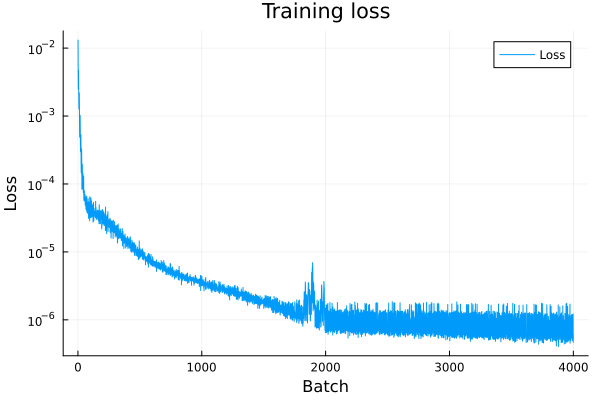

In [7]:
p1 = plot(losses, label="Loss", xlabel="Batch", ylabel="Loss", yscale=:log10, title="Training loss")
display(p1)

In [8]:
function unroll(model, x0, n_times)
    x = reshape(x0, size(x0, 1), size(x0, 2), 1)
    outputs = zeros(Float32, size(x0, 1), size(x0, 2), n_times)
    outputs[:,:,1] .= x0
    
    for t in 1:(n_times-1)
       x = model(x)
        outputs[:,:,t+1] .= x
    end
    return outputs
end

y_unroll = unroll(model, x0, n_times);

[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/unrolling.gif


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/unrolling.gif")
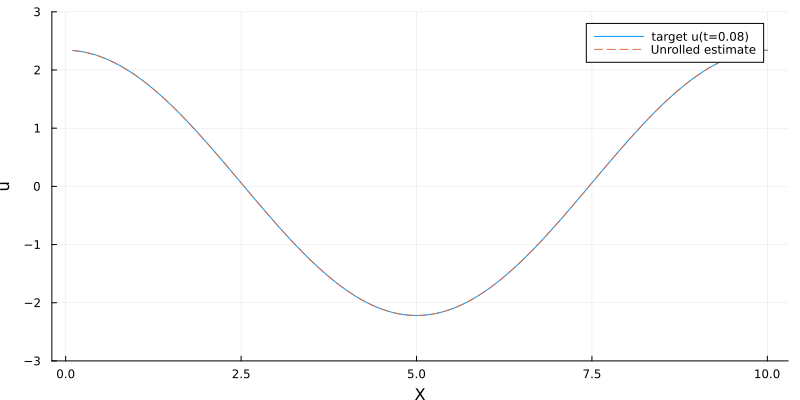

In [9]:
begin
    anim = @animate for i in 1:length(output_times)
        p1 = plot(output_x, X[:,1,i], xlabel="X", ylabel="u", label="target u(t=$(round(output_times[i],digits=2)))")
        plot!(output_x, y_unroll[:,1,i], label="Unrolled estimate", linestyle=:dash, legend=:topright, ylim=(-3,3))
        plot(p1, size=(800,400))
    end
    gif(anim, "unrolling.gif", fps=15)
end
        

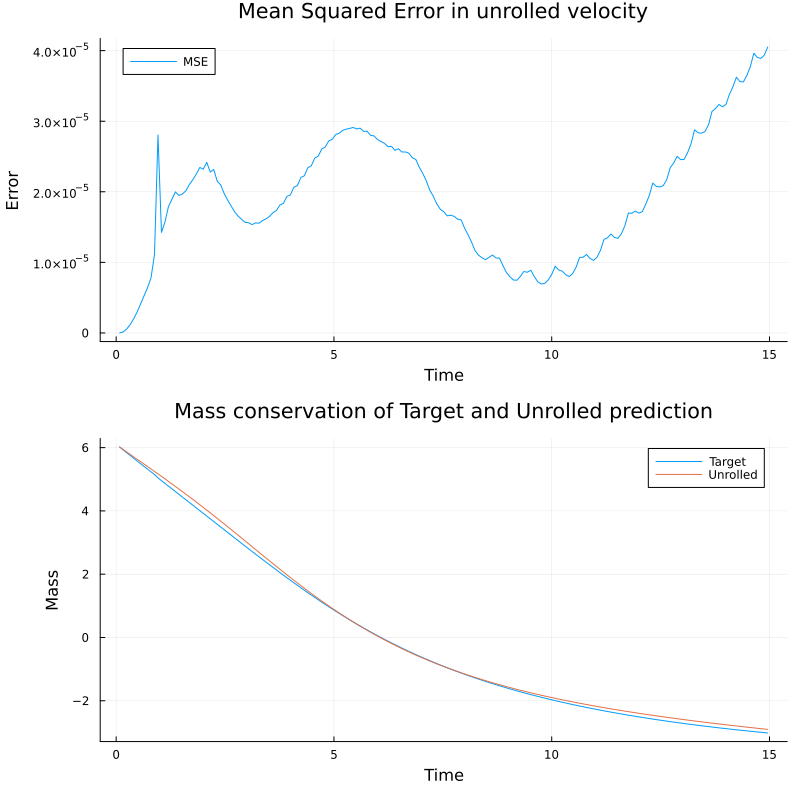

In [10]:
errors = zeros(n_steps)
data_masses = zeros(n_steps)
unrolled_masses = zeros(n_steps)
for i in 1:n_steps
    errors[i] = mean(abs2, y_unroll[:,1,i] .- X[:,1,i])
    data_masses[i] = sum(X[:,1,i])
    unrolled_masses[i] = sum(y_unroll[:,1,i])
end
p0 = plot(output_times, errors, xlabel="Time", ylabel="Error", label="MSE", title="Mean Squared Error in unrolled velocity")
p1 = plot(output_times, data_masses, xlabel="Time", ylabel="Mass", label="Target")
plot!(p1, output_times, unrolled_masses, label="Unrolled", title="Mass conservation of Target and Unrolled prediction")
fig = plot(p0, p1, layout=(2,1), size=(800,800))
display(fig)